# Data Analysis

## Imports

In [1]:
!pip install geopandas

In [2]:
from google.colab import drive
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import ast
import sys
import seaborn as sns
import matplotlib.colors as mcolors
from geopandas import GeoDataFrame
import networkx as nx

## Drive Setup

In [8]:
city_name = "Chicago"
mini = False

In [9]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [10]:
personal_dir = "./gdrive/MyDrive/DeliverAI Data Folder/"
data_dir = f"{personal_dir}{city_name}_mini - RL Delivery Data" if mini else f"{personal_dir}{city_name} - RL Delivery Data"

# See directory content
data = os.listdir(data_dir)
print("Files in directory : ", data)

Files in directory :  ['Original Location Data', 'Processed Location Data', 'Census Data', 'Hotspot Data', 'Results', 'Images', 'Q Tables', 'avg_hotspot_data.json']


### Variables

In [11]:
superspot_hotspot_ratio = 15
min_children = superspot_hotspot_ratio - 3

## Load Data

In [12]:
census_df = gpd.read_file(data_dir + "/Census Data/census_tract_data.geojson")

# Import distance/time data from graphhopper
distance_matrix = np.load(data_dir + f"/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/distance_adjacency_matrix.npy")
time_matrix = np.load(data_dir + f"/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/time_adjacency_matrix.npy")

gh_df = pd.read_csv(data_dir + f'/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/graphhopper_dataframe.csv', dtype={'GEOID': 'string'}).drop(["Unnamed: 0"], axis=1)
gh_df['children'] = gh_df['children'].apply(ast.literal_eval)

superspot_df = gpd.read_file(data_dir + f"/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/layered_hotspots.geojson")
hotspot_df = gpd.read_file(data_dir + f"/Hotspot Data/hotspot_data.geojson")
superspot_df['children'] = superspot_df['children'].apply(ast.literal_eval)

In [13]:
len(gh_df[gh_df['is_super']].index)

29

## Analysis

#### Relationship btwn. Num. Children & Locations

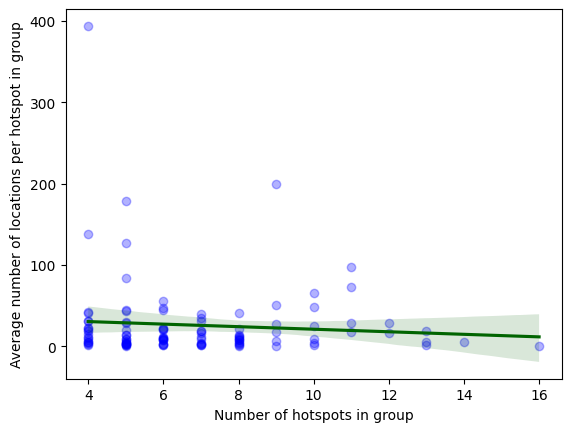

In [ ]:
# Use gh_df to make new dataframe
# Each row is data point, with columns: GEOID, num_locations, total_num_locations, num_children
#   total_num_locations should include all locations in group

# gh_df

ch_loc_df = superspot_df[superspot_df['is_super']].drop(['score', 'geometry', 'super_tract'], axis=1)
ch_loc_df['num_children'] = ch_loc_df['children'].apply(lambda x: len(x))
ch_loc_df['avg_loc_per_child'] = ch_loc_df['total_locations'] / ch_loc_df['num_children']
# ch_loc_df = ch_loc_df[ch_loc_df['total_locations'] > 0]

sns.regplot(y='avg_loc_per_child', x='num_children', data=ch_loc_df, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "darkgreen"}, fit_reg=True)

plt.xlabel("Number of hotspots in group")
plt.ylabel("Average number of locations per hotspot in group")


plt.show()

In [ ]:
ch_loc_df['children_loc_list'] = [[] for _ in range(len(ch_loc_df.index))]

for idx, row in ch_loc_df.iterrows():
  print(row['GEOID'], end="\t")
  for child in row['children']:
    tract = superspot_df[superspot_df['GEOID'] == child].iloc[0]
    row['children_loc_list'].append(tract['locations'])

  print(row['children_loc_list'])

ch_loc_df['median_loc_per_child'] = ch_loc_df['children_loc_list'].apply(lambda x: np.median(x))

In [ ]:
ch_loc_df_filt = ch_loc_df[ch_loc_df['median_loc_per_child'] < 55]
sns.regplot(y='median_loc_per_child', x='num_children', data=ch_loc_df_filt, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "darkgreen"}, fit_reg=True)
sns.regplot(y='median_loc_per_child', x='num_children', data=ch_loc_df[ch_loc_df['median_loc_per_child'] >= 55], scatter_kws={"color": "red", "alpha": 0.3}, fit_reg=False)

plt.xlabel("Number of hotspots in group")
plt.ylabel("Median number of locations per hotspot in group")
plt.title("Median, outliers removed")
plt.show()

## Maps

https://geojson.io/#map=11.94/41.8777/-87.65084

https://docs.google.com/drawings/d/1PNsS0qjPxpTxprJvNZE_JFRGB9wKXLy9nK4toi-66UY/edit

#### City Subsection Selection Tool

Define the census tract limit and region of map to select from below

In [89]:
# Available regions: top_left, top_right, bottom_left, bottom_right, central
selected_region = "top_right"
map_lim = 30

##### Variable Initialization

In [78]:
gdf = census_df
gdf["geometry"] = gdf["geometry"].buffer(0)
fs = (10, 10)

minx, miny, maxx, maxy = gdf.total_bounds
# Regions to raondomly select from
regions = {
    "top_left": (
      (minx, (minx + maxx) / 2),
      ((miny + maxy) / 2, maxy)
    ),
    "top_right": (
      ((minx + maxx) / 2, maxx),
      ((miny + maxy) / 2, maxy)
    ),
    "bottom_left": (
      (minx, (minx + maxx) / 2),
      (miny, (miny + maxy) / 2)
    ),
    "bottom_right": (
      ((minx + maxx) / 2, maxx),
      (miny, (miny + maxy) / 2)
    ),
    "central": (
        ((minx + maxx) / 4, (3 * (minx + maxx)) / 4),
        ((miny + maxy) / 4, (3 * (miny + maxy)) / 4),
    )
}

##### Select Tract

!!!	Randomly selected tract ID: 17031063301
____________________________________________________________________________________________________ 





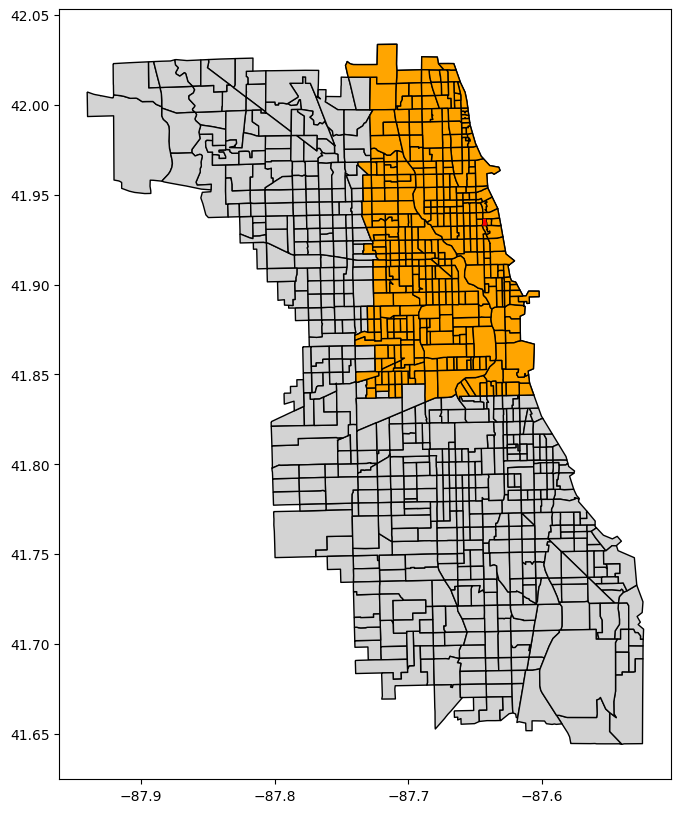

In [97]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Filter tracts in selected region
(x_range, y_range) = regions[selected_region]
region_gdf = gdf[
    (gdf.geometry.centroid.x >= x_range[0])
    & (gdf.geometry.centroid.x <= x_range[1])
    & (gdf.geometry.centroid.y >= y_range[0])
    & (gdf.geometry.centroid.y <= y_range[1])
]

# Randomly select one tract from the filtered tracts
if not region_gdf.empty:
    random_tract = region_gdf.sample(1)  # Random tract selection

    # Print info
    print("!!!\tRandomly selected tract ID:", random_tract['GEOID'].iloc[0])
    print("_"*100, "\n\n\n")

    # Set seed_index to random_tract for region selection in next step
    seed_index = random_tract.iloc[0]['GEOID']

    # Plot region and selected tract
    gdf.plot(color="lightgrey", edgecolor="black", figsize=fs)
    region_gdf.plot(color="orange", edgecolor="black", ax=plt.gca(), figsize=fs)
    random_tract.plot(color="red", ax=plt.gca(), figsize=fs)
else:
    print(f"No tracts found in the {selected_region} region.")

##### Select Subset Region
Done iteratively until:

(a) No unselected tracts left in graph

(b) Limit met

In [100]:
# seed_index = gdf.iloc[0]['GEOID']  # Start with the first tract
selected_indices = {seed_index}  # Initialize selection with the seed
remaining_indices = set(gdf['GEOID']) - selected_indices  # Remaining tracts to consider

while remaining_indices:
  curr_geoms = gdf[gdf['GEOID'].isin(selected_indices)]['geometry']

  neighbors = gdf[gdf['GEOID'].isin(remaining_indices)]
  neighbors = neighbors[neighbors.geometry.apply(
    lambda geom: curr_geoms.apply(lambda x: x.touches(geom)).any()
  )]

  # Get GEOIDs of newly selected neighbors
  new_indices = set(neighbors['GEOID'])

  # Update selected and remaining lists
  selected_indices.update(new_indices)
  remaining_indices -= new_indices

  if len(selected_indices) >= map_lim:
    break


selected_indices = list(selected_indices)

print("Original size:", len(selected_indices))
# overflow_lim = int(map_lim*1.1)
# if len(selected_indices) > overflow_lim:
#   selected_indices = selected_indices[:overflow_lim]
# print("New size:", len(selected_indices))

sub_gdf = gdf[gdf['GEOID'].isin(selected_indices)]
print("GEOID list:", selected_indices)

GEOID list: ['17031062900', '17031071400', '17031062200', '17031060900', '17031063303', '17031061800', '17031070102', '17031071600', '17031063301', '17031071300', '17031071100', '17031832600', '17031832000', '17031063100', '17031071500', '17031061901', '17031063000', '17031070103', '17031062000', '17031063200', '17031063400', '17031070200', '17031070400', '17031071800', '17031063302', '17031071200', '17031070300', '17031061902', '17031070101', '17031071000', '17031062100']


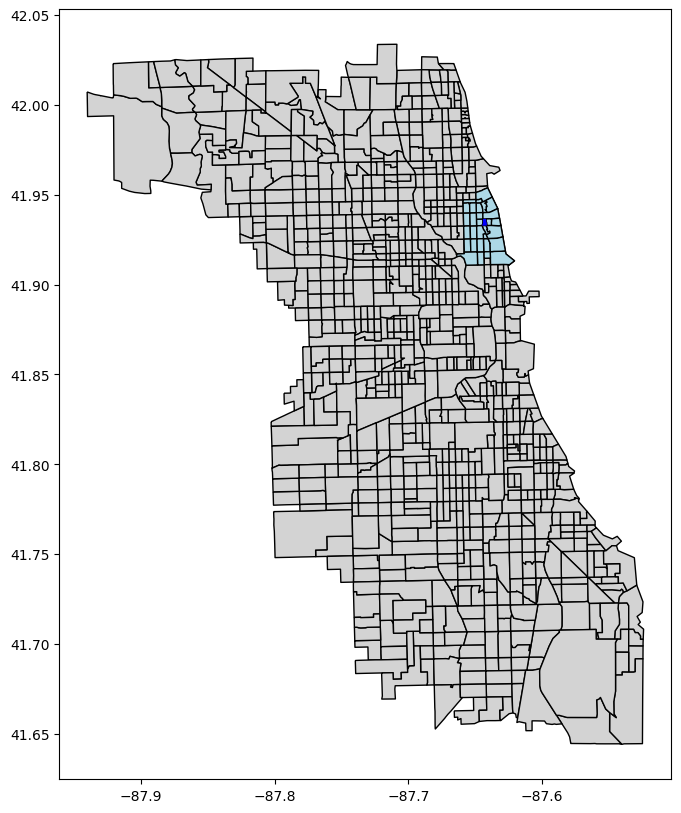

In [99]:
SELECTED_GEOIDS = ['17031062900', '17031071400', '17031062200', '17031060900', '17031063303', '17031061800', '17031070102', '17031071600', '17031063301', '17031071300', '17031071100', '17031832600', '17031832000', '17031063100', '17031071500', '17031061901', '17031063000', '17031070103', '17031062000', '17031063200', '17031063400', '17031070200', '17031070400', '17031071800', '17031063302', '17031071200', '17031070300', '17031061902', '17031070101', '17031071000', '17031062100']

gdf.plot(color="lightgrey", edgecolor="black", figsize=fs)
sub_gdf.plot(color="lightblue", edgecolor="black", ax=plt.gca(), figsize=fs)
random_tract.plot(color="blue", ax=plt.gca(), figsize=fs)
plt.show()

#### Full City

<Axes: >

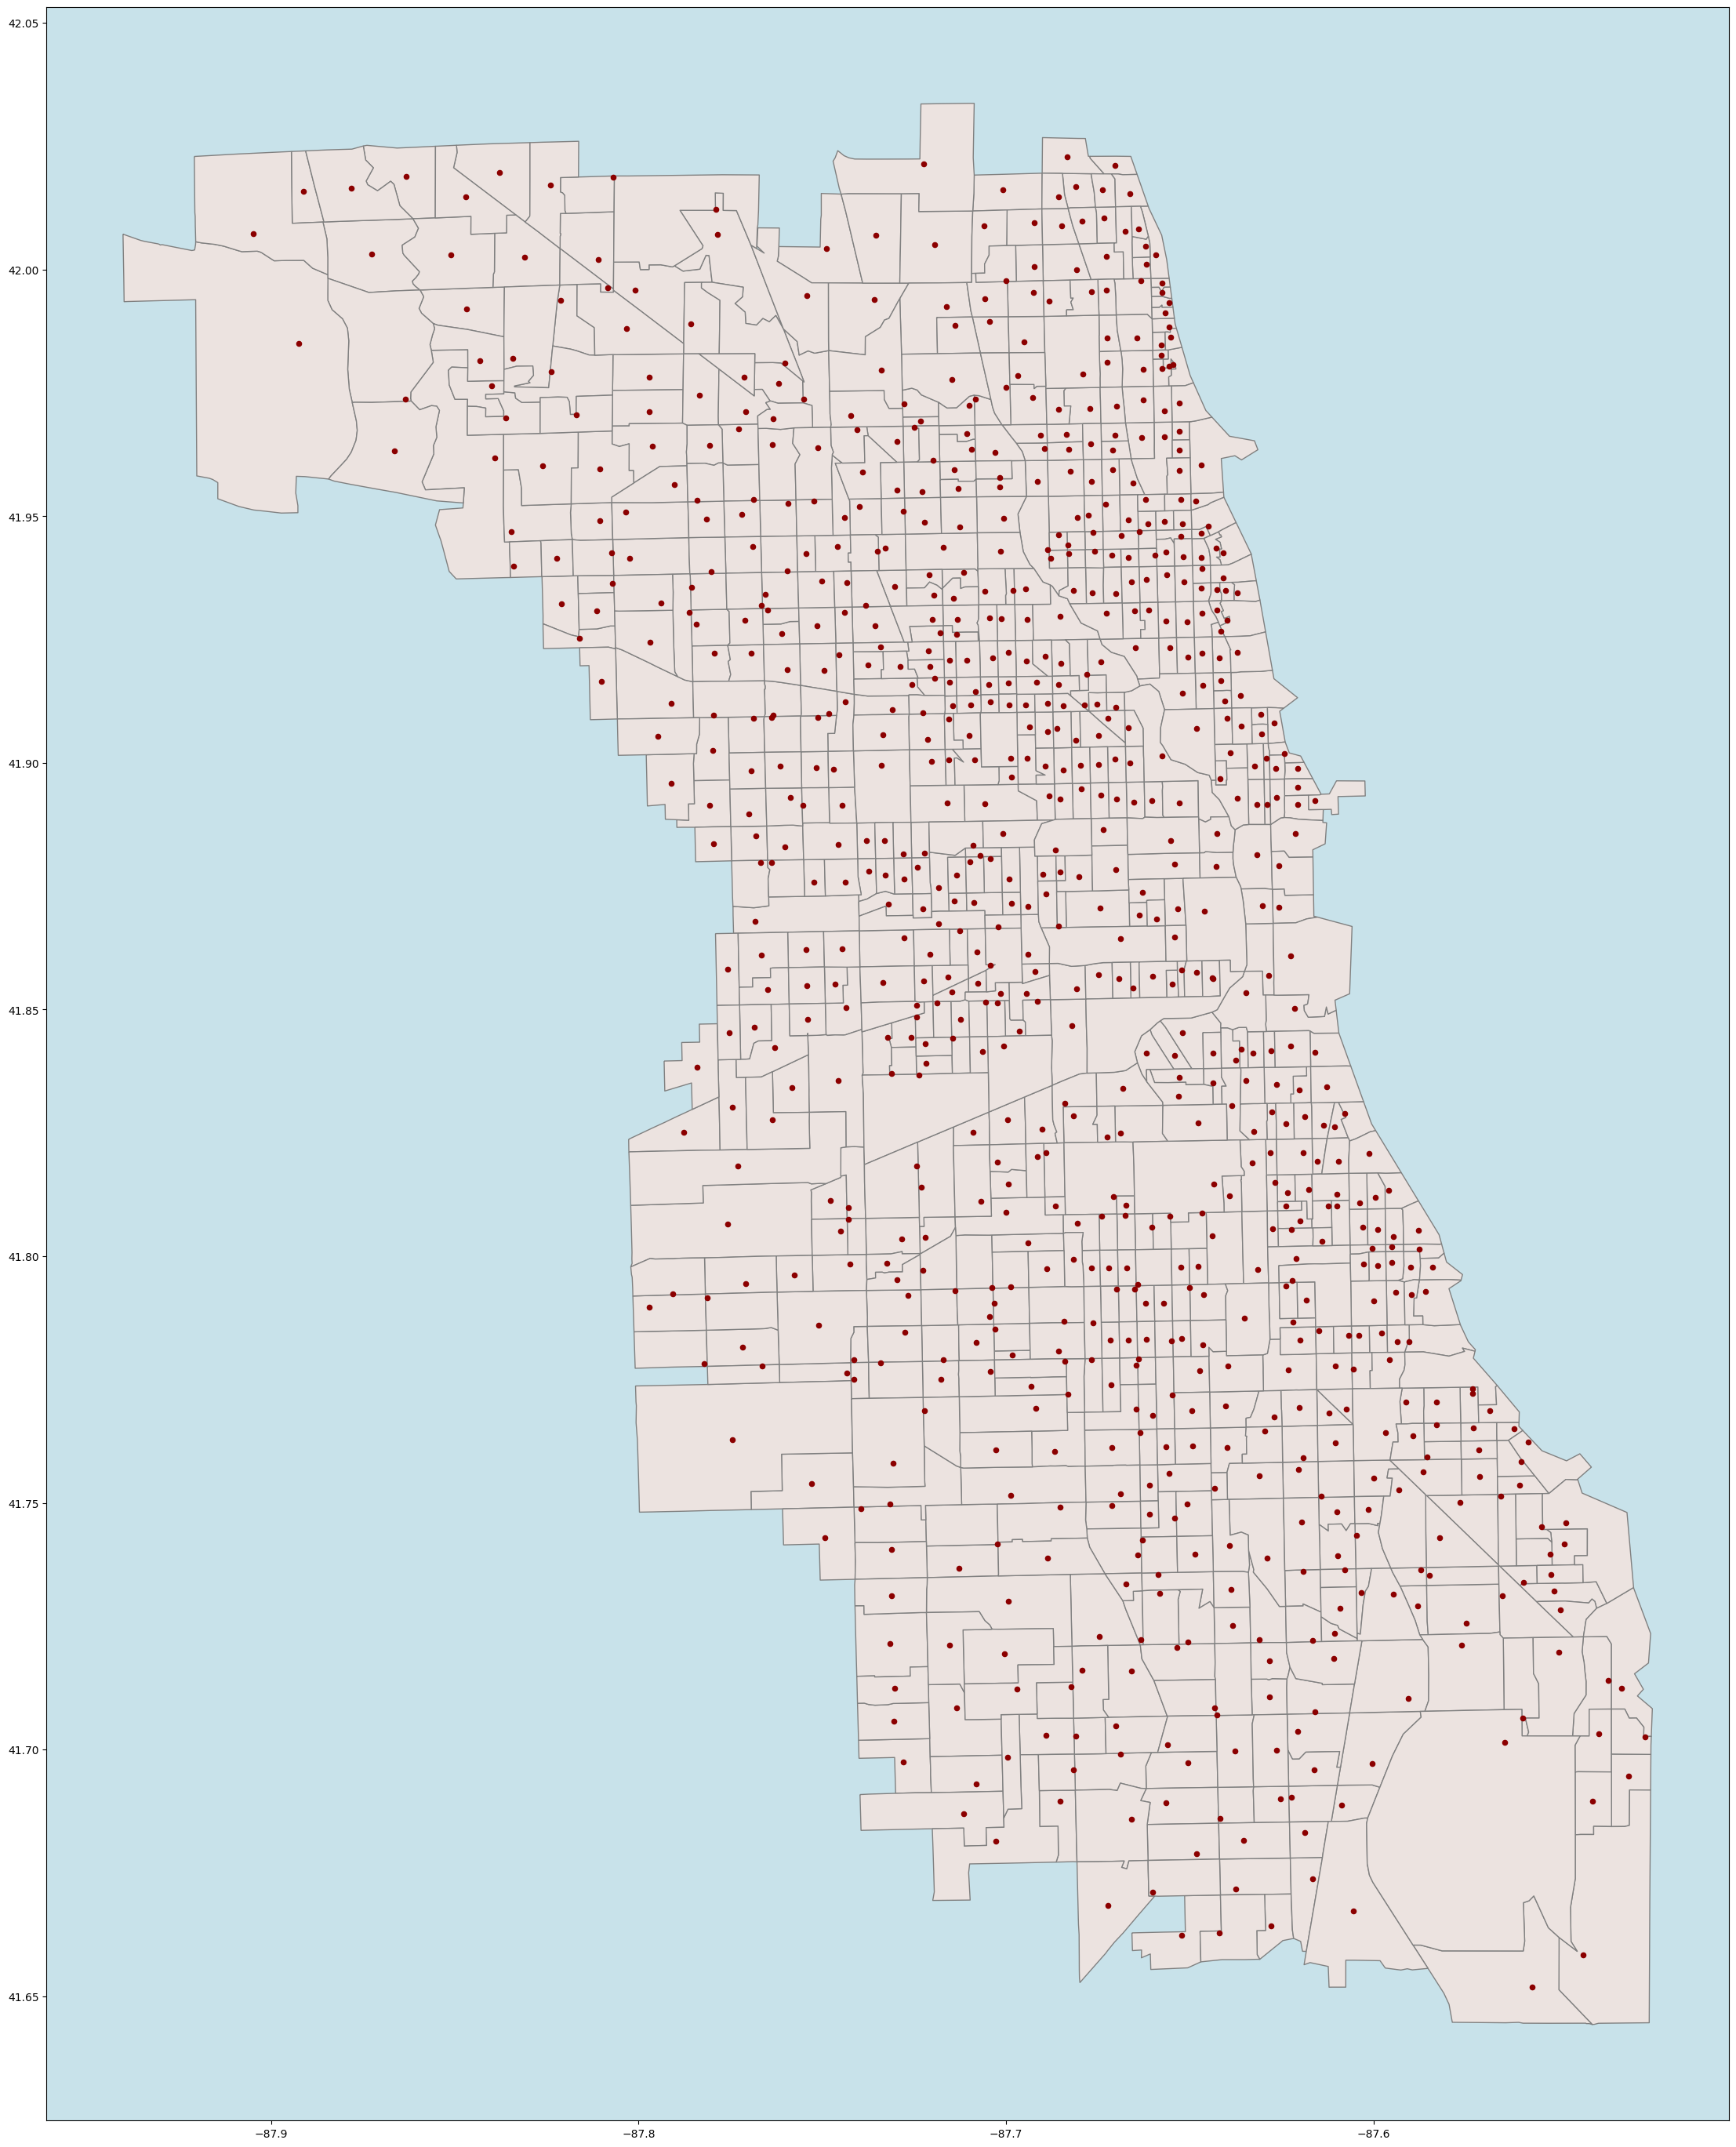

In [ ]:
fig, ax = plt.subplots(1, figsize=(35, 35))
ax.set_facecolor('#c8e2ea')
census_df.plot(ax=ax, color='#ece3e0', edgecolor='grey')  # #d8c6c0
hotspot_df.plot(ax=ax, color='darkred', markersize=20)

#### Grouped City - No Color

In [ ]:
merged_geom_cache = {}

# Function to merge children geometries for super tracts
def merge_children_geometries(row, gdf):
  super_id = row['GEOID']  # Assuming superspots have unique GEOIDs
  if super_id in merged_geom_cache:  # Check if already cached
    return merged_geom_cache[super_id]

  children_ids = row['children']
  children_ids.append(row['GEOID'])
  children_geometries = gdf[gdf['GEOID'].isin(children_ids)]
  if not children_geometries.empty:
    merged_geometry = children_geometries.unary_union
    merged_geom_cache[super_id] = merged_geometry  # Cache the result
    return merged_geometry
  return None

<ipython-input-13-1eeea4354270>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))


<Axes: >

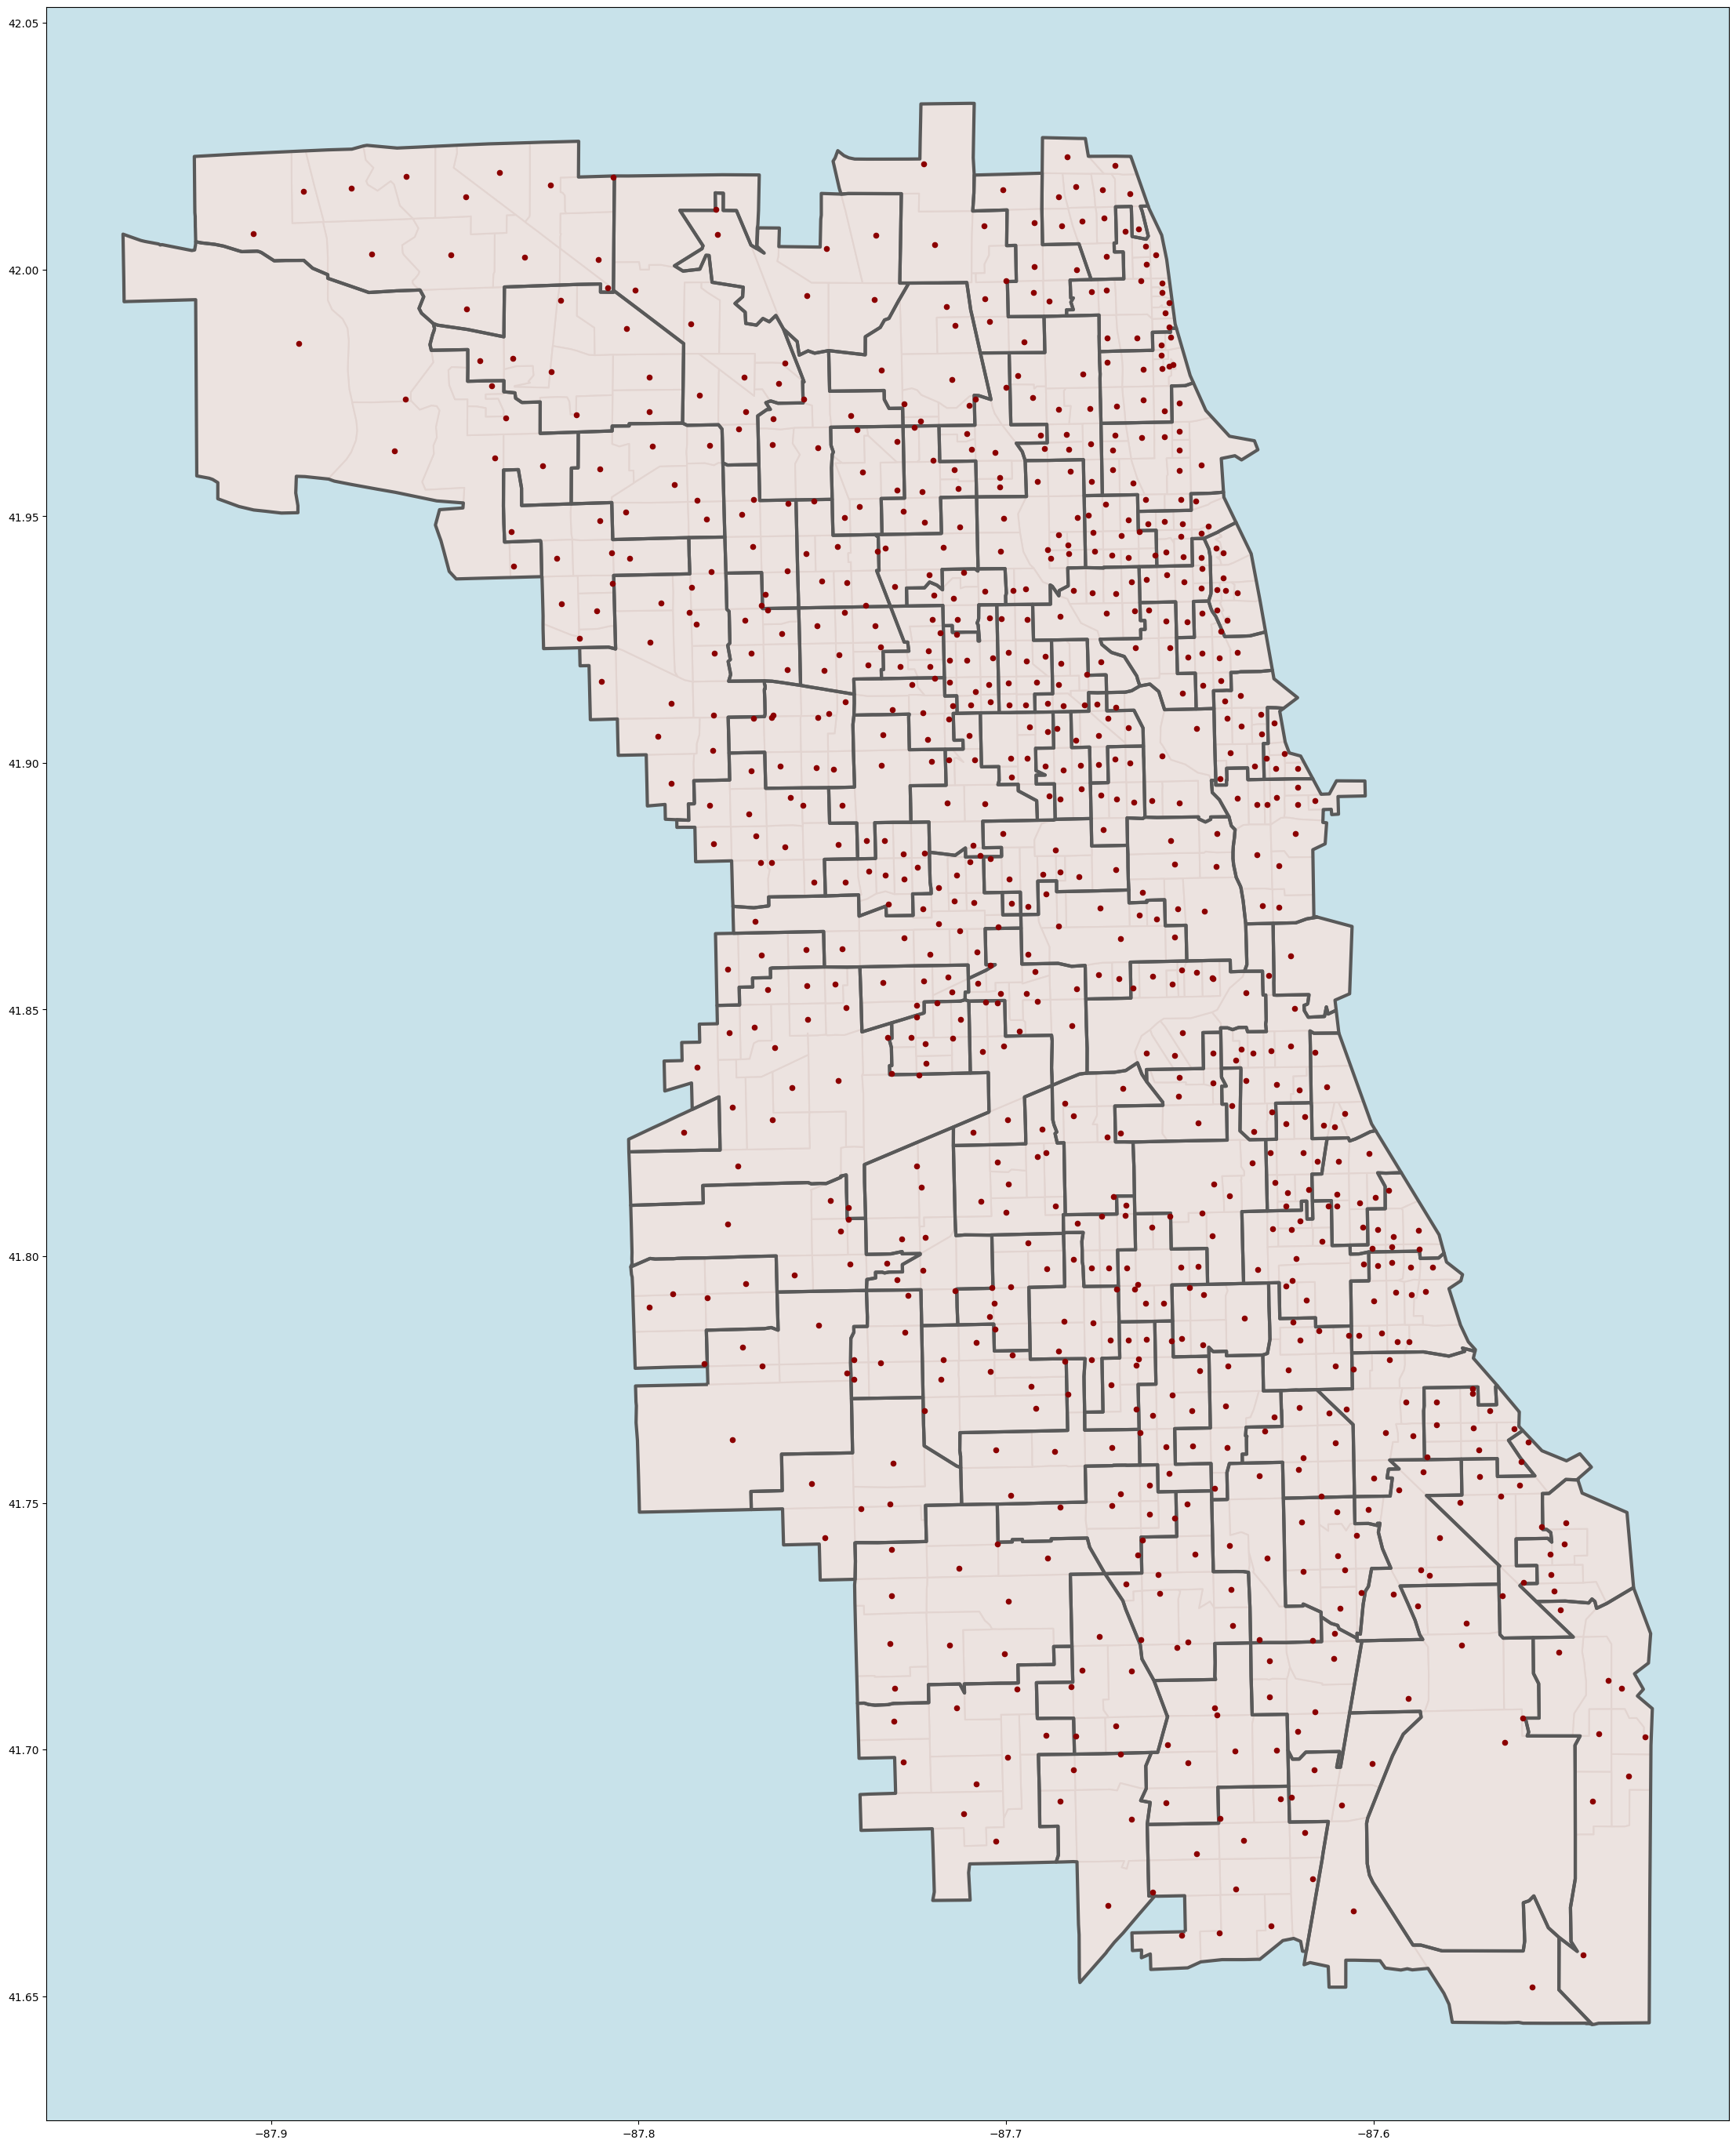

In [ ]:
fig, ax = plt.subplots(1, figsize=(35, 35))
ax.set_facecolor('#c8e2ea')

# Colormap for unique coloring of groups
colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))


# for idx, (row, color) in enumerate(zip(superspot_df[superspot_df['is_super']].iterrows(), colormap.colors)):
#   _, row = row
#   merged_geom = merge_children_geometries(row, superspot_df)  # Cached call
#   if merged_geom:  # If not none, exists. Therefore...
#     gpd.GeoSeries([merged_geom]).plot(ax=ax, color='#ece3e0', edgecolor='none', linewidth=0)


superspot_df.plot(ax=ax, color='#ece3e0', facecolor="none", linewidth=1.5, edgecolor='#e2d4d0')


for idx, (row, color) in enumerate(zip(superspot_df[superspot_df['is_super']].iterrows(), colormap.colors)):
  _, row = row
  merged_geom = merge_children_geometries(row, superspot_df)  # Cached call
  if merged_geom:  # If not none, exists. Therefore...
    gpd.GeoSeries([merged_geom]).plot(ax=ax, color='none', edgecolor='#595959', linewidth=3)


# Plot hotspots and superspots separately
hotspots = GeoDataFrame(superspot_df[['GEOID', 'is_super']].merge(hotspot_df))
hotspots.plot(ax=ax, color='darkred', markersize=20)

<ipython-input-15-5731affc438d>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))


<Axes: >

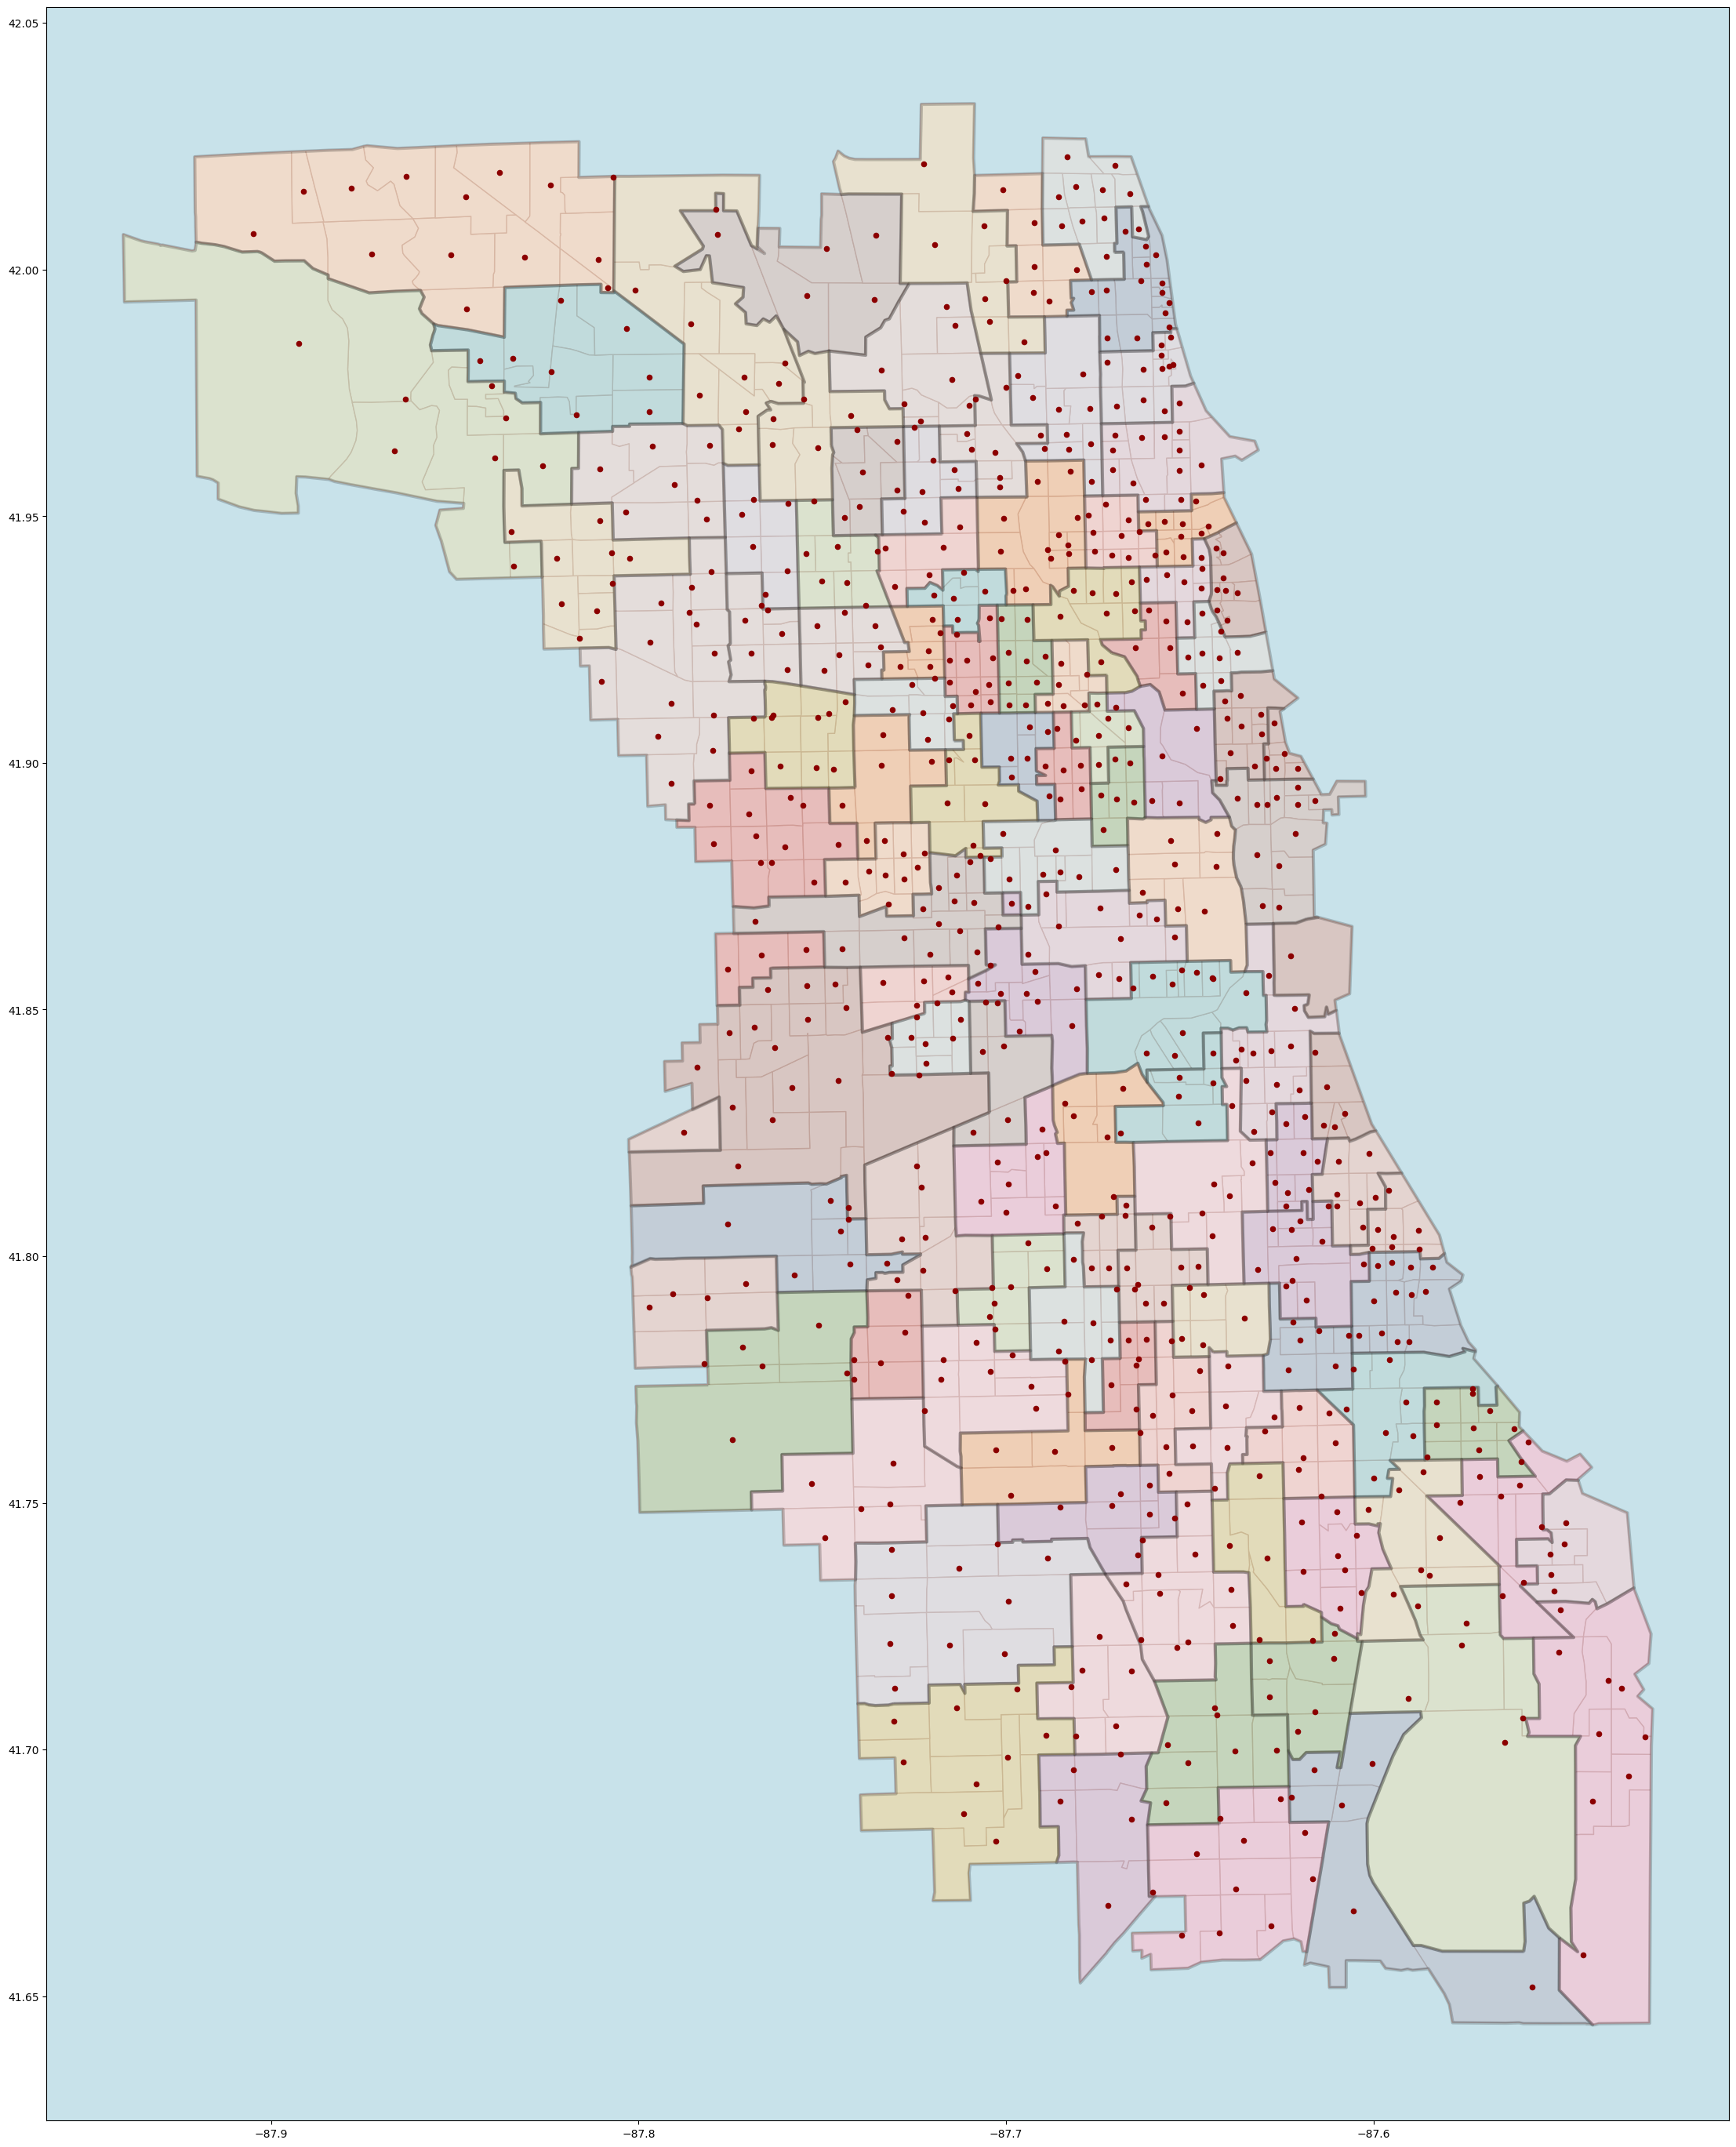

In [ ]:
fig, ax = plt.subplots(1, figsize=(35, 35))
ax.set_facecolor('#c8e2ea')
superspot_df.plot(ax=ax, color='#ece3e0', edgecolor='#cfb7b0')

# Colormap for unique coloring of groups
colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))

# Plot groups with unique colors
for idx, (row, color) in enumerate(zip(superspot_df[superspot_df['is_super']].iterrows(), colormap.colors)):
  _, row = row
  merged_geom = merge_children_geometries(row, superspot_df)  # Cached call
  if merged_geom:  # If not none, exists. Therefore...
    gpd.GeoSeries([merged_geom]).plot(ax=ax, color=mcolors.to_hex(color), edgecolor='black', linewidth=3, alpha=0.2)  # Plot group slightly transparent

# Plot hotspots
hotspots = GeoDataFrame(superspot_df[['GEOID', 'is_super']].merge(hotspot_df))
hotspots.plot(ax=ax, color='darkred', markersize=20)

#### Grouped City

In [ ]:
fig, ax = plt.subplots(1, figsize=(35, 35))
ax.set_facecolor('#c8e2ea')
superspot_df.plot(ax=ax, color='#ece3e0', edgecolor='#e2d4d0')

# Colormap for unique coloring of groups
colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))

# Plot groups with unique colors
for idx, (row, color) in enumerate(zip(superspot_df[superspot_df['is_super']].iterrows(), colormap.colors)):
  _, row = row
  merged_geom = merge_children_geometries(row, superspot_df)  # Cached call
  if merged_geom:  # If not none, exists. Therefore...
    gpd.GeoSeries([merged_geom]).plot(ax=ax, color=mcolors.to_hex(color), edgecolor='black', linewidth=3, alpha=0.2)  # Plot group slightly transparent

# Plot hotspots and superspots separately
hotspots = GeoDataFrame(superspot_df[['GEOID', 'is_super']].merge(hotspot_df))
hotspots_super = hotspots[hotspots['is_super']]
hotspots_not_super = hotspots[~hotspots['is_super']]

hotspots_not_super.plot(ax=ax, color='darkred', markersize=20)  # darkred
hotspots_super.plot(ax=ax, color='blue', markersize=70, marker='*')  # #d15400

<ipython-input-12-d9c2f6965c46>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(superspot_df[superspot_df['is_super']]))


<Axes: >

## Demonstration of Data Matrix

In [ ]:
with open(data_dir + f"/Hotspot Data/map_geoid_index.json", 'r') as f:
    geoid_ind = json.load(f)
ind_geoid = {v: k for k, v in geoid_ind.items()}

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

def print_matrix(matrix):
    global ind_geoid

    modified_matrix = np.where(matrix > 1000000, -1, matrix)

    index_labels = [ind_geoid[i][-4:] for i in range(len(matrix))]  # Setting row labels
    columns_labels = [ind_geoid[i][-4:] for i in range(len(matrix))]  # Setting col labels

    print(pd.DataFrame(modified_matrix, columns=columns_labels, index=index_labels))

In [ ]:
print_matrix(distance_matrix)

      1300  1400  2000  2510  2520  7830  2100  1000  1810  1902  2800  3200  3600  8500  1110  1200  1500  1700  1820  2200  2300  3000  2900  1600  1121  1901
1300     0  2454    -1    -1    -1    -1    -1  1881  2202    -1    -1    -1    -1    -1  2167  1664    -1    -1    -1    -1    -1    -1    -1    -1  1622    -1
1400  2396     0    -1    -1    -1    -1    -1  3964  4287    -1    -1    -1    -1    -1  4834  2556    -1    -1    -1    -1    -1    -1    -1    -1  3541    -1
2000    -1    -1     0    -1    -1  3600    -1    -1    -1  3203    -1   795    -1  2020    -1    -1    -1    -1   848    -1    -1    -1    -1    -1    -1  1922
2510    -1    -1    -1     0  3364    -1    -1    -1    -1    -1  3169    -1  7584    -1    -1    -1  4168    -1    -1    -1  8359    -1  4071    -1    -1    -1
2520    -1    -1    -1  3379     0    -1    -1    -1    -1    -1   898    -1  2369    -1    -1    -1  6411    -1    -1    -1  4497    -1  2133    -1    -1    -1
7830    -1    -1  3603    -1    -1

In [ ]:
# G = nx.from_numpy_array(distance_matrix, create_using=nx.DiGraph)

# # Print the edges of the graph
# print(G.edges())

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), 

## Formulation of Leeway Calculation

### Classes and methods copied from simulation Colab

In [ ]:
import pickle
from shapely.geometry import shape

def convert_str_to_int(d):
  return {int(k) if k.isdigit() else k: int(v) if isinstance(v, str) and v.isdigit() else v for k, v in d.items()}

with open(data_dir + f"/Q Tables/Data-{min_children}-{superspot_hotspot_ratio}/tract_super_dict.json", 'r') as f:
  tract_super_dict = convert_str_to_int(json.load(f))

with open(data_dir + "/Hotspot Data/map_geoid_index.json", 'r') as f:
  tract_to_index = json.load(f)
index_to_tract = {v: k for k, v in tract_to_index.items()}

estimate_dist_matrix = np.load(data_dir + f"/Hotspot Data/estimate_distance_adjacency_matrix.npy")
estimate_time_matrix = np.load(data_dir + f"/Hotspot Data/estimate_time_adjacency_matrix.npy")

full_dist_matrix = np.load(data_dir + f"/Hotspot Data/full_distance_adjacency_matrix.npy")
full_time_matrix = np.load(data_dir + f"/Hotspot Data/full_time_adjacency_matrix.npy")

In [ ]:
class Delivery:
  id = 0
  def __init__(self, start_node, end_node, start_time, percent):
    self.id = Delivery.id
    Delivery.id += 1
    self.start_node = start_node
    self.start_node_super = tract_super_dict[self.start_node]
    self.end_node = end_node
    self.end_node_super = tract_super_dict[self.end_node]
    self.current_node = start_node
    self.time_till_next_node = 0
    self.start_time = start_time
    self.end_time = None
    self.time_limit =  None
    self.in_transition = False
    self.is_primary = True
    self.next_node = None
    self.sharing_node = None
    self.completed = False
    self.successful = False
    self.num_car_changes = 2 #For initial change from PDC to CDV and for the final change to CDV to PDC
    self.sharing_with = None
    self.path = [self.start_node]
    self.distance_traveled = 0
    self.percent_max_dist = percent
    self.step = self.set_step(percent)


    ###DEBUG VARIABLES
    self.did_share = False
    self.shared_with_final = None
    self.shared_with_when = None

  def set_time_limit(self):
    self.time_limit = max(full_time_matrix[self.start_node][self.end_node], 900)  # Give it time limit of 15 minutes or distance needed to travel depending on which is bigger.

  def state_4_condition(self, percent):
    # Are census tracts in different groups?
    different_groups = self.start_node_super != self.end_node_super

    # Are census tracts bordering?
    polygon1 = shape(census_df[census_df['GEOID'] == index_to_tract[self.start_node]].iloc[0]['geometry'])
    polygon2 = shape(census_df[census_df['GEOID'] == index_to_tract[self.end_node]].iloc[0]['geometry'])

    bordering = polygon1.touches(polygon2)

    # Are the hotspots close enough for direct delivery?
    max_distance = max(estimate_dist_matrix.argmax(), full_dist_matrix.argmax())

    close_proximity = full_dist_matrix[self.start_node, self.end_node] / max_distance <=  percent / 100


    # Must be in different groups, if bordering or close enough (these conditions technically overlap), return true else false
    return different_groups and (bordering or close_proximity)

  def set_step(self, percent):
    if self.state_4_condition(percent):
      step_val = 4
    elif self.start_node_super == self.end_node_super:
      step_val = 3
    elif self.start_node_super != self.end_node_super and self.start_node_super == self.start_node:
      step_val = 2
    else:
      step_val = 1

    return step_val

  def reset(self, percent=-1):
    percent = self.percent_max_dist if percent == -1 else percent

    self.current_node = self.start_node
    self.time_till_next_node = 0
    self.end_time = None
    self.set_time_limit()
    self.in_transition = False
    self.is_primary = True
    self.next_node = None
    self.sharing_node = None
    self.completed = False
    self.successful = False
    self.num_car_changes = 2 #For initial change from PDC to CDV and for the final change to CDV to PDC
    self.sharing_with = None
    self.path = [self.start_node]
    self.distance_traveled = 0
    self.step = self.set_step(percent)


    ###DEBUG VARIABLES
    self.did_share = False
    self.shared_with_final = None
    self.shared_with_when = None


  def __lt__(self, other):
    if self.start_time != other.start_time:
      return self.start_time < other.start_time
    elif len(self.path) != len(other.path):
      return len(self.path) < len(other.path)
    else:
      return self.id < other.id

  def __str__(self):
    return f"Delivery {self.id}\n" \
           f"Start Time: \t {self.start_time}\n" \
           f"Start Hotspot: \t {self.start_node}\n" \
           f"End Hotspot: \t {self.end_node}\n" \
           f"In Transition: \t {self.in_transition}\n" \
           f"Time limit: \t {self.time_limit}\n" \
           f"Time left: \t {self.time_till_next_node}\n" \
           f"Current Hotspot: {self.current_node}\n" \
           f"Next Hotspot: \t {self.next_node}\n" \
           f"Step: \t {self.step}\n" \
           f"Sharing With: \t {self.sharing_with.id if self.sharing_with is not None else None} \n" \
           f"Shared With Final: \t {self.shared_with_final} \n" \
           f"Shared With When: \t {self.shared_with_when} \n" \
           f"Path: \t \t {self.path}\n" \
           f"Completed: \t {self.completed}\n"


In [ ]:
def load_deliveries(distance_based="random", load=5, percent_max_dist=70, hours=1, graphing=False):

  def gen_deliveries_id(distance_based, load, hours, percent_max_dist):
    id_str = ""

    # distance_based:
    #  - Random: 0
    #  - Further: 1
    #  - Closer: 2
    #  - One_Cluster: 3
    match distance_based:
      case "Further":
        id_str += "1"
      case "Closer":
        id_str += "2"
      case "One_Cluster":
        id_str += "3"
      case _:
        id_str += "0"

    # Adds a buffer of zeroes plus the load (4 characters total)
    load_str = str(load)
    id_str += "-" + "0" * (4 - len(load_str)) + load_str

    hours_str = str(hours)
    id_str += "-" + "0" * (3 - len(hours_str)) + hours_str

    percent_max_dist_str = str(percent_max_dist)
    id_str += "-" + "0" * (3 - len(percent_max_dist_str)) + percent_max_dist_str

    return id_str

  deliveries_dir = data_dir + f"/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/Deliveries"

  if graphing:
    deliveries_dir += "/Graphing"

  deliveries_id = gen_deliveries_id(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)

  with open(deliveries_dir + f"/{deliveries_id}", 'rb') as file:
    deliveries = pickle.load(file)

  return deliveries

### Delivery Loading and Analysis

In [ ]:
superspot_hotspot_ratio = 15
min_children = superspot_hotspot_ratio - 3

distance_based="random"
load = 300
hours=1
percent_max_dist=100

In [ ]:
deliveries = load_deliveries(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)
print(len(deliveries))

13866


Look at distribution of start times for deliveries

In [ ]:
y = [d.start_time for d in deliveries]
plt.hist(y, bins=13, edgecolor='black', alpha=0.7)

(array([ 587.,  950., 1299., 1386., 1242., 1019.,  890., 1036., 1239.,
        1385., 1287.,  966.,  580.]),
 array([1.00000000e+00, 2.77846154e+02, 5.54692308e+02, 8.31538462e+02,
        1.10838462e+03, 1.38523077e+03, 1.66207692e+03, 1.93892308e+03,
        2.21576923e+03, 2.49261538e+03, 2.76946154e+03, 3.04630769e+03,
        3.32315385e+03, 3.60000000e+03]),
 <BarContainer object of 13 artists>)

Function that gets how many standard deviations away from

In [ ]:
def sd_diff(delivery):  # , time_val
  DELIVERY_LEEWAY_FACTOR = 2

  # IMPORTANT: I am defining these manually assuming they will not change
  #  and that hours = 1.
  total_seconds = 3600
  peak1 = 0.25  # (15 minutes in, 25% of an hour)
  peak2 = 0.75  # (45 minutes in, 75% of an hour)
  sd = 1.0/6.0  # (10 minutes,  1/6th of an hour)

  peak_diff = min(abs(total_seconds*peak1 - delivery.start_time), abs(total_seconds*peak2 - delivery.start_time))

  # Now we determine how many std. deviations away from that peak it is closer to.
  num_sd_away = peak_diff / (total_seconds*sd)

  return num_sd_away

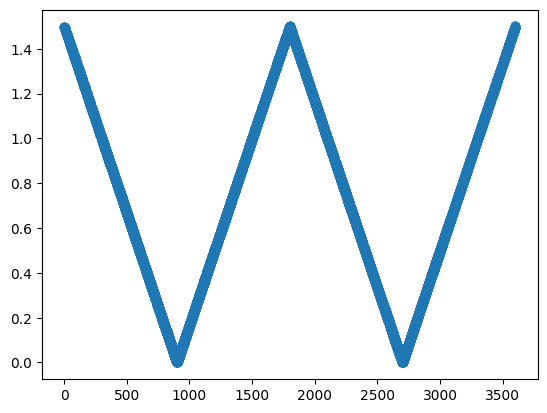

In [ ]:
y = [sd_diff(d) for d in deliveries]
x = [d.start_time for d in deliveries]
plt.scatter(x, y)

In [ ]:
def get_delivery_timelimits(delivery):
  DELIVERY_LEEWAY_FACTOR = 2

  # IMPORTANT: I am defining these manually assuming they will not change
  #  and that hours = 1.
  total_seconds = 3600
  peak1 = 0.25  # (15 minutes in, 25% of an hour)
  peak2 = 0.75  # (45 minutes in, 75% of an hour)
  sd = 1.0/6.0  # (10 minutes,  1/6th of an hour)

  # This determines which peak (first or second) the delivery is closer to. Then it gets the time difference between that
  #  peak and the delivery starting time.
  peak_diff = min(abs(total_seconds*peak1 - delivery.start_time), abs(total_seconds*peak2 - delivery.start_time))

  # Now we determine how many std. deviations away from that peak it is closer to.
  num_sd_away = peak_diff / (total_seconds*sd)

  # Given this current distribution, a delivery can be at most 1.5 standard deviations away from either of the two peaks
  #  The closer to the peak, the more time we want to give a delivery.
  #  In our formulation, we will use the equation L * (2.5 - S), where L is the leeway multiplier and S how many
  #    standard deviations away the delivery start time is from a peak. So when a delivery is the max possible
  #    standard deviations away from a peak, its leeway will be L, otherwise it will be boosted as it is approaching
  #    peak hours.

  if delivery.time_limit == 900:
    return np.array([0, delivery.time_limit,
                   delivery.time_limit * (2.5 - num_sd_away) - delivery.time_limit])

  return np.array([0, delivery.time_limit * DELIVERY_LEEWAY_FACTOR - delivery.time_limit,
                   delivery.time_limit * DELIVERY_LEEWAY_FACTOR * max(1, (2 - num_sd_away)) - delivery.time_limit])

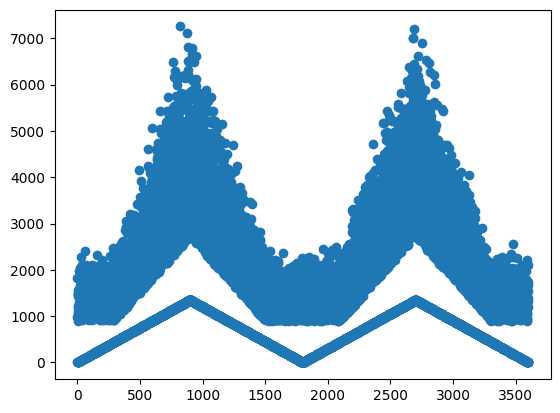

In [ ]:
y_array = np.array([get_delivery_timelimits(d) for d in deliveries])
x = [d.start_time for d in deliveries]
plt.scatter(x, y_array[:, 2])  # Doesn't account for multiple deliveries at the same time but with differing distances, update this figure to account for that.

In [ ]:
y_array = np.array([get_delivery_timelimits(d) for d in deliveries])
x = [d.start_time for d in deliveries]
plt.scatter(x, y_array[:, 2])  # Doesn't account for multiple deliveries at the same time but with differing distances, update this figure to account for that.

### Creating an alternative method of time limit creation

In [ ]:
superspot_hotspot_ratio = 15
min_children = superspot_hotspot_ratio - 3

distance_based="random"
load = 300
hours=1
percent_max_dist=100

deliveries = load_deliveries(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)
print(len(deliveries))

13866


In [ ]:
path_times = [full_time_matrix[d.start_node, d.end_node] for d in deliveries]

In [ ]:
intervals = [600, 900, 1200, 1500, 1800, 2700, 3600, 5400, 7200, 10800, 14400]

10.0
15.0
20.0
25.0
30.0
45.0
60.0
90.0
120.0
180.0
240.0


In [ ]:
path_limits = []
for path_time in path_times:
  for interval in intervals:
    if path_time*2 <= interval:
      path_limits.append(interval)
      break

In [ ]:
path_times.sort()
path_limits.sort()

x = range(len(path_times))
plt.plot(x, path_times)
plt.plot(x, path_limits)

## Analysis of Avg Hotspot Data

In [ ]:
with open(data_dir + "/avg_hotspot_data.json") as f:
  avg_hotspot_data = json.load(f)

<Axes: >

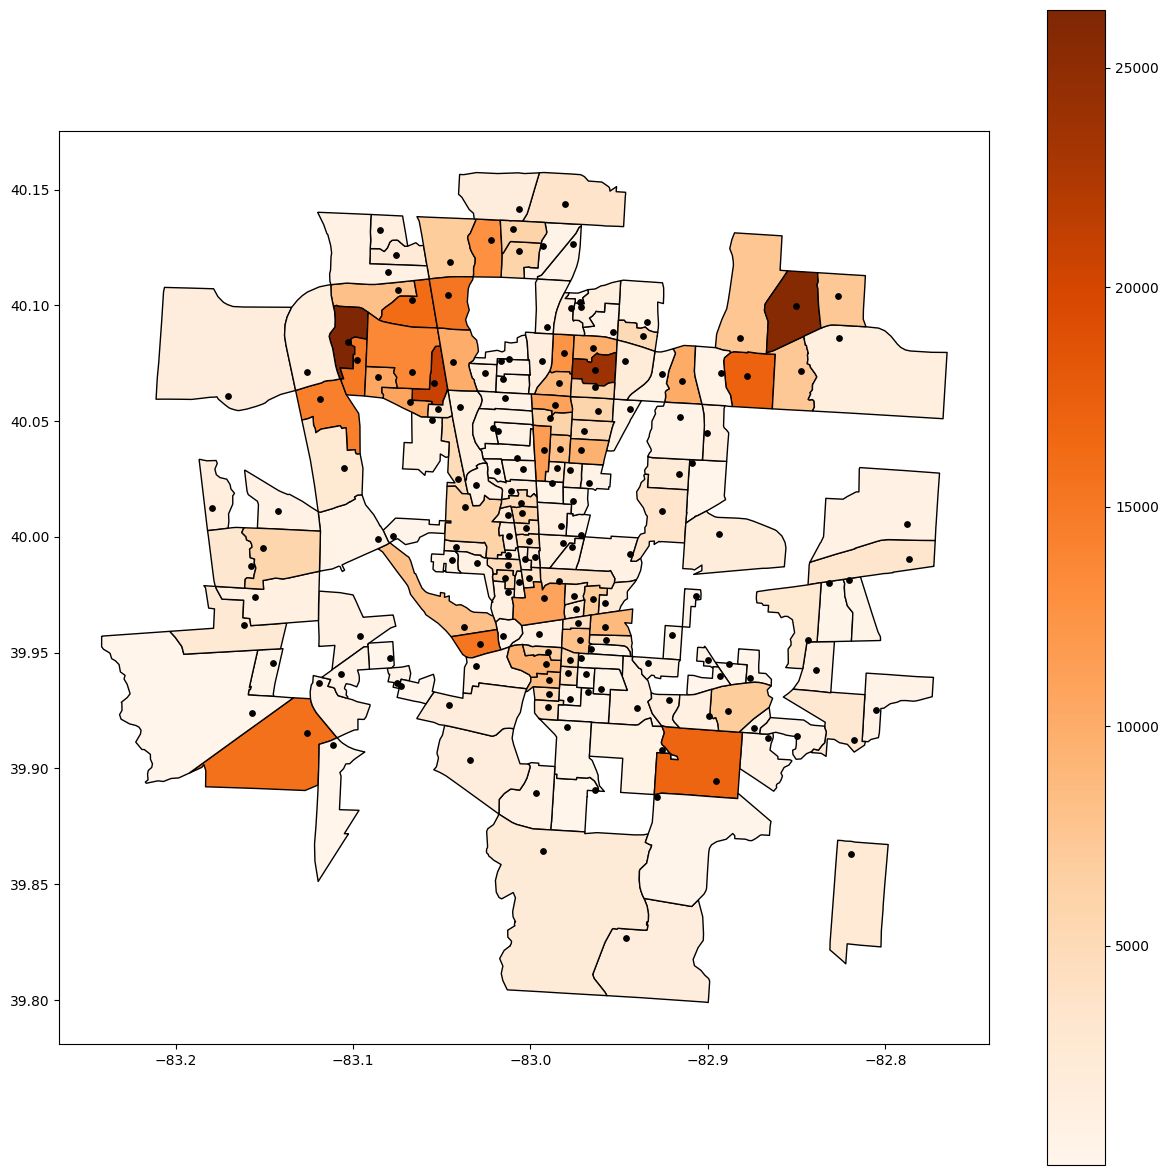

In [ ]:
avg_hs_df = census_df.copy()
avg_hs_df['avg_hotspot_data'] = np.nan

for geoid, data in avg_hotspot_data.items():
  avg_hs_df.loc[avg_hs_df['GEOID'] == geoid, 'avg_hotspot_data'] = data['distance']

avg_hs_df = avg_hs_df[(avg_hs_df['avg_hotspot_data'] < 100000)]
avg_hs_df = avg_hs_df[(avg_hs_df['avg_hotspot_data'] != 0)]

norm = plt.Normalize(vmin=avg_hs_df['avg_hotspot_data'].min(), vmax=avg_hs_df['avg_hotspot_data'].max())

fig, ax = plt.subplots(1, figsize=(15, 15))

# Create the plot with the colormap
avg_hs_df.plot(ax=ax, column='avg_hotspot_data', cmap='Oranges', edgecolor='black', legend=True)
hotspot_df[hotspot_df['GEOID'].isin(avg_hs_df['GEOID'])].plot(ax=ax, color='black', markersize=15)

In [ ]:
with open (data_dir + "/Census Data/census_tract_wise_locations.json") as f:
  dd = json.load(f)

In [ ]:
building_counts = {}
search_word = "cafe"  # Specify the word to search for

for tract_data in dd.values():
    for location in tract_data:
        for value in location.values():  # Iterate through all values in 'location'
            if search_word in str(value):  # Check if the search word is present in the string representation of the value
                building_type = location['amenity']
                building_counts[building_type] = building_counts.get(building_type, 0) + 1
                break  # Move to the next location after finding the search word


In [ ]:
pd.DataFrame(list(building_counts.items()), columns=['Building Type', 'Total Count'])

Building Type  Total Count
0          cafe           57

In [ ]:
dd['17031110300']

[{'id': 'way/163226336',
  'amenity': 'restaurant',
  'building': 'yes',
  'shop': None,
  'lat': 41.97640912000001,
  'lon': -87.78689098},
 {'id': 'way/163188413',
  'amenity': None,
  'building': 'detached',
  'shop': None,
  'lat': 41.9726803,
  'lon': -87.78015954}]

In [ ]:
list(dd.values())[0][0]

{'id': 'way/28357149',
 'amenity': None,
 'building': 'retail',
 'shop': 'supermarket',
 'lat': 41.97909940909091,
 'lon': -87.65920717272728}

In [ ]:
C = 'Philadelphia'

count = 0

pick_data_dir = f"{personal_dir}{C} - RL Delivery Data" + "/Original Location Data/Pickup Point Data/"  # Pickup vs Drop
pick_files = os.listdir(pick_data_dir)
print(pick_files)
for file_name in pick_files:
  file_dir = pick_data_dir + file_name
  file_df = gpd.read_file(file_dir)
  count += len(file_df.index)

print(count)

['restaurant_raw_data.geojson', 'cafe_raw_data.geojson', 'food_court_raw_data.geojson', 'fast_food_raw_data.geojson', 'bakery_raw_data.geojson', 'supermarket_raw_data.geojson']
445


In [ ]:
import pickle

S = 10

deliveries_graphing_dir = f"{personal_dir}{C} - RL Delivery Data" + f"/Hotspot Data/Data-{S-3}-{S}/Deliveries/Graphing"
with open (deliveries_graphing_dir + f"sim_results", 'rb') as fp:
  res_dist = pickle.load(fp)

with open (deliveries_graphing_dir + f"baseline_results", 'rb') as fp:
  base1_dist = pickle.load(fp)


percs_to_check = range(101)

plt.figure(figsize=(10,6))
plt.plot(percs_to_check, res_dist, label='res_dist', color='b')
plt.plot(percs_to_check, base1_dist, label='base1_dist', color='r')

min_perc = percs_to_check[np.argmin(res_dist)]
plt.vlines(x = min_perc, ymin = min(res_dist)-100, ymax = max(res_dist)+100, colors = 'purple', linestyle = ':')
plt.text(x=min_perc+2, y=max(res_dist)-50, s=f'{min_perc}%', fontsize = 14, color='darkred')


plt.xlabel('Minimum Percentage of Max Distance to Allow Order Sharing (%)', fontsize=15)
plt.ylabel('Total Distance (meters)', fontsize=15)
plt.title(f'{C} - Minimum Percentage vs Total Distance for B1 & R', fontsize=18)
plt.legend()
plt.grid(True)